# CS559 Final Project
## House Price Prediction Competition
### Project 8 - Adam Szyluk, Jaswant Golla, Naga sudheer kumar Somepalli

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR

### Feature Engineering

In [54]:
DF = pd.read_csv("train.csv")

In [55]:
DF.drop("Unnamed: 0", axis=1, inplace=True)
DF.drop("Id", axis=1, inplace=True)

In [56]:
DF[DF.columns[DF.isnull().any()].tolist()].isnull().sum()

LotFrontage      180
Alley            962
MasVnrType       614
MasVnrArea         7
BsmtQual          29
BsmtCond          29
BsmtExposure      30
BsmtFinType1      29
BsmtFinType2      30
FireplaceQu      480
GarageType        54
GarageYrBlt       54
GarageFinish      54
GarageQual        54
GarageCond        54
PoolQC          1017
Fence            824
MiscFeature      990
dtype: int64

In [57]:
DF.drop("MiscFeature", axis=1, inplace=True)
DF.drop("PoolQC", axis=1, inplace=True)
DF.drop("Fence", axis=1, inplace=True)
DF.drop("MasVnrType", axis=1, inplace=True)
DF.drop("Alley", axis=1, inplace=True)

In [58]:
DF_str = DF.select_dtypes(include=[np.object_])
DF_str.nunique(axis=0)

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     24
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      13
Exterior2nd      15
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           5
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        6
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [59]:
for col in DF_str:
    index = 0
    vals = {}
    for s in DF_str[col].unique():
        vals[s] = index
        index += 1
    DF[col] = DF_str[col].map(vals)

DF.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,0,NaN,9375,0,0,0,0,0,0,...,0,0,0,0,0,2,2009,0,0,219500
1,70,0,60.0,9084,0,0,0,0,0,0,...,0,0,0,0,0,10,2009,0,0,108000
2,80,0,120.0,19296,0,0,0,0,1,0,...,252,0,0,0,0,5,2009,0,0,176000
3,120,1,37.0,3316,0,1,0,0,0,0,...,0,0,0,0,0,4,2006,0,0,197000
4,20,0,73.0,7100,0,1,0,0,1,0,...,0,0,0,0,0,7,2006,0,0,129900


In [60]:
DF[DF.columns[DF.isnull().any()].tolist()].isnull().sum()

LotFrontage    180
MasVnrArea       7
GarageYrBlt     54
dtype: int64

In [61]:
DF["LotFrontage"].fillna(np.average(DF["LotFrontage"].notnull().values), inplace=True)
DF.dropna(inplace=True)
DF[DF.columns[DF.isnull().any()].tolist()].isnull().sum()

Series([], dtype: float64)

In [62]:
corr_matrix = DF.corr().abs()
vals = corr_matrix.values
np.fill_diagonal(vals, -2)

corr_matrix[:] = vals
s = corr_matrix.unstack()

so = s.sort_values(kind="quicksort", ascending=False)
so[so > 0.5]

Exterior2nd   Exterior1st     0.855600
Exterior1st   Exterior2nd     0.855600
YearBuilt     GarageYrBlt     0.831379
GarageYrBlt   YearBuilt       0.831379
GarageArea    GarageCars      0.829205
GarageCars    GarageArea      0.829205
TotRmsAbvGrd  GrLivArea       0.819000
GrLivArea     TotRmsAbvGrd    0.819000
TotalBsmtSF   1stFlrSF        0.813778
1stFlrSF      TotalBsmtSF     0.813778
SalePrice     OverallQual     0.785074
OverallQual   SalePrice       0.785074
BldgType      MSSubClass      0.748087
MSSubClass    BldgType        0.748087
GrLivArea     SalePrice       0.719996
SalePrice     GrLivArea       0.719996
FireplaceQu   Fireplaces      0.683017
Fireplaces    FireplaceQu     0.683017
BsmtFinSF2    BsmtFinType2    0.680872
BsmtFinType2  BsmtFinSF2      0.680872
YearBuilt     Foundation      0.675561
Foundation    YearBuilt       0.675561
OverallQual   ExterQual       0.673942
ExterQual     OverallQual     0.673942
TotRmsAbvGrd  BedroomAbvGr    0.661819
BedroomAbvGr  TotRmsAbvGr

In [63]:
pd.options.display.max_rows = 4000
corr_matrix["SalePrice"].abs().sort_values(ascending=False)

SalePrice        2.000000
OverallQual      0.785074
GrLivArea        0.719996
GarageCars       0.627508
ExterQual        0.626013
GarageArea       0.609731
1stFlrSF         0.601427
TotalBsmtSF      0.601232
FullBath         0.567495
TotRmsAbvGrd     0.557519
YearBuilt        0.530998
YearRemodAdd     0.502868
GarageYrBlt      0.483471
MasVnrArea       0.465017
Fireplaces       0.464369
Foundation       0.450144
BsmtFinSF1       0.384620
FireplaceQu      0.355776
HeatingQC        0.354427
BsmtFinType1     0.350354
OpenPorchSF      0.313377
2ndFlrSF         0.307075
WoodDeckSF       0.290470
MSZoning         0.287883
HalfBath         0.268545
HouseStyle       0.261649
LotShape         0.261042
LotArea          0.246781
CentralAir       0.235186
Electrical       0.228391
BsmtFullBath     0.224496
BsmtUnfSF        0.218930
LotFrontage      0.213375
BsmtExposure     0.197845
Neighborhood     0.183522
PavedDrive       0.179952
BedroomAbvGr     0.174910
BsmtCond         0.165304
GarageFinish

In [64]:
# Highly correlated features, combinable
DF['YrBlt'] = DF[['YearBuilt', 'GarageYrBlt', 'YearRemodAdd']].mean(axis=1)
DF['Garage'] = DF[['GarageCars', 'GarageArea']].sum(axis=1)
DF['LivingArea'] = DF[['TotRmsAbvGrd', 'GrLivArea']].sum(axis=1)
DF['TotalSF'] = DF[['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']].sum(axis=1)
DF['TotRms'] = DF['TotRmsAbvGrd'] + DF['KitchenAbvGr']

# Dropping features that are considered by the above engineered features or OverallQual/OverallCond.
DF = DF.drop(['FullBath', 'HalfBath', 'BedroomAbvGr', '1stFlrSF', '2ndFlrSF', 'BsmtUnfSF',
                'ExterQual', 'KitchenQual', 'BsmtQual', 'GarageQual',
                'BsmtCond', 'GarageCond', 'ExterCond', 'TotRmsAbvGrd', 
                'KitchenAbvGr', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 'GarageCars', 'GarageArea', 'GrLivArea',
                'TotalBsmtSF'], axis=1)

# Highly correlated features, not combinable, one feature low significance to SalePrice
DF.drop("MSSubClass", axis=1, inplace=True)
DF.drop("FireplaceQu", axis=1, inplace=True)

# Low significance to SalePrice
low_corr_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType2', 'Condition2', 'MiscVal',
                        'BsmtHalfBath', '3SsnPorch', 'SaleCondition', 'MoSold',
                        'Heating', 'Condition1', 'LowQualFinSF', 'LandContour', 'LandSlope',
                        'Exterior1st', 'Exterior2nd', 'YrSold', 'LotConfig', 'Street', 'Utilities']

DF = DF.drop(low_corr_features, axis=1)
DF.head(5)

,MSZoning,LotFrontage,LotArea,LotShape,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,...,EnclosedPorch,ScreenPorch,PoolArea,SaleType,SalePrice,YrBlt,Garage,LivingArea,TotalSF,TotRms
0,0,0.823875,9375,0,0,0,0,7,5,0,...,0,0,0,0,219500,1997.666667,647,2042,3091,9
1,0,60.000000,9084,0,1,0,0,4,5,0,...,0,0,0,0,108000,1943.333333,297,1517,2265,8
2,0,120.000000,19296,0,2,0,1,6,5,0,...,252,0,0,0,176000,1971.666667,886,1388,2744,7
3,1,37.000000,3316,1,3,1,2,8,5,0,...,0,0,0,0,197000,2005.000000,552,1251,2494,5
4,0,73.000000,7100,1,2,0,2,5,7,0,...,0,0,0,0,129900,1957.000000,309,821,1632,6


Now we have 35 features excluding SalePrice (which is what we are trying to find). Here's a function to neatly perform feature engineering on a file.

In [65]:
def perform_feature_engineering(file_name):
    df = pd.read_csv(file_name)

    df['TotalSF'] = df[['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']].sum(axis=1)

    df = df.drop(['FullBath', 'HalfBath', 'BedroomAbvGr', '1stFlrSF', '2ndFlrSF', 'BsmtUnfSF',
                  'ExterQual', 'KitchenQual', 'BsmtQual', 'GarageQual', 'MiscFeature', 'Fence',
                  'MasVnrType', 'Unnamed: 0', 'Id', 'PoolQC', 'Utilities', 'Street', 'Alley'], axis=1)

    df['TotRms'] = df['TotRmsAbvGrd'] + df['KitchenAbvGr']

    df = df.dropna(subset=['GarageYrBlt'])
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

    df['YrBlt'] = df[['YearBuilt', 'GarageYrBlt', 'YearRemodAdd']].mean(axis=1)
    df['Garage'] = df[['GarageCars', 'GarageArea']].sum(axis=1)
    df['LivingArea'] = df[['TotRmsAbvGrd', 'GrLivArea']].sum(axis=1)

    df = df.drop(['TotRmsAbvGrd', 'KitchenAbvGr', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 'GarageCars', 'GarageArea', 'GrLivArea', 'MSSubClass', 'FireplaceQu', 'TotalBsmtSF',
                  'BsmtCond', 'GarageCond', 'ExterCond'], axis=1)

    low_corr_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType2', 'Condition2', 'MiscVal',
                         'BsmtHalfBath', '3SsnPorch', 'SaleCondition', 'MoSold',
                         'Heating', 'Condition1', 'LowQualFinSF', 'LandContour', 'LandSlope',
                         'Exterior1st', 'Exterior2nd', 'YrSold', 'LotConfig']
    df = df.drop(low_corr_features, axis=1)

    df = df.dropna()

    df_str = df.select_dtypes(include=[np.object_])
    
    for col in df_str:
        index = 0
        vals = {}
        for s in df_str[col].unique():
            vals[s] = index
            index += 1
        df[col] = df_str[col].map(vals)

    return df

train_file = 'train.csv'
test_file = 'test.csv'

train_df = perform_feature_engineering(train_file)
test_df = perform_feature_engineering(test_file)

print(train_df.head())
print(test_df.head())

   MSZoning  LotFrontage  LotArea  LotShape  Neighborhood  BldgType  \
0         0         70.0     9375         0             0         0   
1         0         60.0     9084         0             1         0   
2         0        120.0    19296         0             2         0   
3         1         37.0     3316         1             3         1   
4         0         73.0     7100         1             2         0   

   HouseStyle  OverallQual  OverallCond  RoofStyle  ...  EnclosedPorch  \
0           0            7            5          0  ...              0   
1           0            4            5          0  ...              0   
2           1            6            5          0  ...            252   
3           2            8            5          0  ...              0   
4           2            5            7          0  ...              0   

   ScreenPorch  PoolArea  SaleType  SalePrice  TotalSF  TotRms        YrBlt  \
0            0         0         0     219500    

### Finding Clusters

   MSZoning  LotFrontage  LotArea  LotShape  Neighborhood  BldgType  \
0         0         70.0     9375         0             0         0   
1         0         60.0     9084         0             1         0   
2         0        120.0    19296         0             2         0   
3         1         37.0     3316         1             3         1   
4         0         73.0     7100         1             2         0   

   HouseStyle  OverallQual  OverallCond  RoofStyle  ...  EnclosedPorch  \
0           0            7            5          0  ...              0   
1           0            4            5          0  ...              0   
2           1            6            5          0  ...            252   
3           2            8            5          0  ...              0   
4           2            5            7          0  ...              0   

   ScreenPorch  PoolArea  SaleType  SalePrice  TotalSF  TotRms        YrBlt  \
0            0         0         0     219500    

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

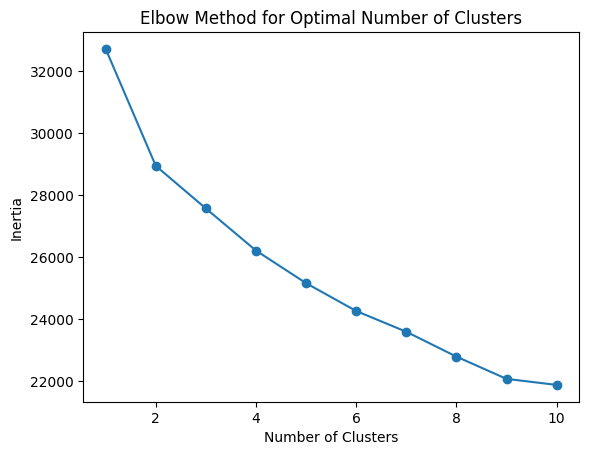

Subgroup
0    401
2    386
1    148
Name: count, dtype: int64


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [66]:
print(train_df.head())

scaler = StandardScaler()
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df.drop(['SalePrice'], axis=1)), columns=train_df.columns[1:])

inertia = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(train_df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

optimal_clusters = 3

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
subgroup_predictions = kmeans.fit_predict(train_df_scaled)

train_df['Subgroup'] = subgroup_predictions

print(train_df['Subgroup'].value_counts())


In [67]:
scaler = StandardScaler()
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df.drop(['SalePrice'], axis=1)), columns=train_df.columns[1:])

num_subgroups = 3

kmeans = KMeans(n_clusters=num_subgroups, random_state=42)
subgroup_predictions = kmeans.fit_predict(train_df_scaled)

train_df['Subgroup'] = subgroup_predictions

print(train_df['Subgroup'].value_counts())

y_subgroup = train_df['Subgroup']

X_train_sub = train_df_scaled.drop(['SalePrice', 'Subgroup'], axis=1)

X_train_subgroup, X_test_subgroup, y_train_subgroup, y_test_subgroup = train_test_split(
    X_train_sub, y_subgroup, test_size=0.2, random_state=42
)

rf_classifier_subgroup = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_subgroup.fit(X_train_subgroup, y_train_subgroup)

y_pred_subgroup = rf_classifier_subgroup.predict(X_test_subgroup)
accuracy_subgroup = accuracy_score(y_test_subgroup, y_pred_subgroup)

print(f'Subgroup Prediction Accuracy: {accuracy_subgroup:.2f}')
print('Classification Report:')
print(classification_report(y_test_subgroup, y_pred_subgroup))

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Subgroup
0    401
1    386
2    148
Name: count, dtype: int64
Subgroup Prediction Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        79
           1       1.00      0.89      0.94        72
           2       0.94      0.83      0.88        36

    accuracy                           0.91       187
   macro avg       0.93      0.90      0.91       187
weighted avg       0.92      0.91      0.91       187



In [68]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier_subgroup = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier_subgroup, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_subgroup, y_train_subgroup)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

y_pred_subgroup_grid_search = grid_search.predict(X_test_subgroup)
accuracy_subgroup_grid_search = accuracy_score(y_test_subgroup, y_pred_subgroup_grid_search)

print(f'Subgroup Prediction Accuracy (GridSearchCV): {accuracy_subgroup_grid_search:.2f}')
print('Classification Report:')
print(classification_report(y_test_subgroup, y_pred_subgroup_grid_search))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validated Accuracy: 0.9344697986577181
Subgroup Prediction Accuracy (GridSearchCV): 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        79
           1       1.00      0.89      0.94        72
           2       0.94      0.81      0.87        36

    accuracy                           0.91       187
   macro avg       0.92      0.89      0.90       187
weighted avg       0.92      0.91      0.91       187



### Model Creation

Hyperparameter tuning:

In [69]:
X = DF.drop('SalePrice', axis=1)
y = DF['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(random_state=42)
svr = SVR()
gbr = HistGradientBoostingRegressor(random_state=42)
dt = DecisionTreeRegressor(random_state=42)

In [70]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated MSE:", -grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validated MSE: 1213878576.2061698


In [71]:
param_grid = {
    'C': [1, 10, 25, 50, 100],
    'epsilon': [1e-3, 1e-2, 1e-1, 1]

}

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated MSE:", -grid_search.best_score_)

Best Parameters: {'C': 100, 'epsilon': 1}
Best Cross-Validated MSE: 6808611460.030043


In [74]:
param_grid = {
    'learning_rate': [0.05, 0.08, 0.1, 0.12, 0.15],
    'max_iter': [100, 250, 500],
    "min_samples_leaf": [1, 2, 4],
    "max_depth": [None, 10, 20, 30],
    "l2_regularization": [1e-1, 1e-2, 1e-3]
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated MSE:", -grid_search.best_score_)

Best Parameters: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'max_iter': 250, 'min_samples_leaf': 2}
Best Cross-Validated MSE: 1156908200.2769465


In [72]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100],
    'criterion': ["friedman_mse", "squared_error"]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated MSE:", -grid_search.best_score_)

Best Parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 10}
Best Cross-Validated MSE: 1643037968.9288752


In [73]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0]
}

grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated MSE:", -grid_search.best_score_)

Best Parameters: {'alpha': 10.0}
Best Cross-Validated MSE: 2174553872.393984


In [75]:
rf = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50)
svr = SVR(C=100, epsilon=1)
gbr = HistGradientBoostingRegressor(random_state=42, l2_regularization=0.01, learning_rate=0.05, max_depth=10, max_iter=250, min_samples_leaf=2)
dt = DecisionTreeRegressor(random_state=42, criterion='friedman_mse', max_depth=None, min_samples_leaf=10)

base_models = [
    ('rf', rf),
    ('svr', svr),
    ("gbr", gbr),
    ("dt", dt)
]

final_estimator = Ridge(alpha=10)

stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=final_estimator
)

stacked_model.fit(X_train_scaled, y_train)

stacked_predictions = stacked_model.predict(X_test_scaled)

mse_stacked = mean_squared_error(y_test, stacked_predictions)
print(f'Stacked Model MSE on Test Set: {mse_stacked:.2f}')

Stacked Model MSE on Test Set: 853541287.43


In [91]:
models = {
    'Random Forest Regressor': rf,
    'Support Vector Regressor': svr,
    'Histogram-based Gradient Boosting Regressor': gbr,
    'Decision Tree Regressor': dt,
    'Ridge': final_estimator
}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy' if 'Classifier' in model_name else 'r2', n_jobs=-1)
    print(f'{model_name} {"Accuracy" if "Classifier" in model_name else "R-squared"}: {scores.mean():.4f} (std: {scores.std():.4f})')

Random Forest Regressor R-squared: 0.8137 (std: 0.0893)
Support Vector Regressor R-squared: 0.0016 (std: 0.0180)
Histogram-based Gradient Boosting Regressor R-squared: 0.7830 (std: 0.1376)
Decision Tree Regressor R-squared: 0.7528 (std: 0.0637)
Ridge R-squared: 0.6635 (std: 0.2605)


Model creation:

In [78]:
# Converted above function to accept df to match test_data_prediction parameter format
def feature_engineering(df):
    df['TotalSF'] = df[['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']].sum(axis=1)

    df = df.drop(['FullBath', 'HalfBath', 'BedroomAbvGr', '1stFlrSF', '2ndFlrSF', 'BsmtUnfSF',
                  'ExterQual', 'KitchenQual', 'BsmtQual', 'GarageQual', 'MiscFeature', 'Fence',
                  'MasVnrType', 'Unnamed: 0', 'Id', 'PoolQC', 'Utilities', 'Street', 'Alley'], axis=1)

    df['TotRms'] = df['TotRmsAbvGrd'] + df['KitchenAbvGr']

    df = df.dropna(subset=['GarageYrBlt'])
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

    df['YrBlt'] = df[['YearBuilt', 'GarageYrBlt', 'YearRemodAdd']].mean(axis=1)
    df['Garage'] = df[['GarageCars', 'GarageArea']].sum(axis=1)
    df['LivingArea'] = df[['TotRmsAbvGrd', 'GrLivArea']].sum(axis=1)

    df = df.drop(['TotRmsAbvGrd', 'KitchenAbvGr', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 'GarageCars', 'GarageArea', 'GrLivArea', 'MSSubClass', 'FireplaceQu', 'TotalBsmtSF',
                  'BsmtCond', 'GarageCond', 'ExterCond'], axis=1)

    low_corr_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType2', 'Condition2', 'MiscVal',
                         'BsmtHalfBath', '3SsnPorch', 'SaleCondition', 'MoSold',
                         'Heating', 'Condition1', 'LowQualFinSF', 'LandContour', 'LandSlope',
                         'Exterior1st', 'Exterior2nd', 'YrSold', 'LotConfig']
    df = df.drop(low_corr_features, axis=1)

    df = df.dropna()

    df_str = df.select_dtypes(include=[np.object_])
    
    for col in df_str:
        index = 0
        vals = {}
        for s in df_str[col].unique():
            vals[s] = index
            index += 1
        df[col] = df_str[col].map(vals)

    return df

def test_data_prediction(train_data, test_data):
    train_data = feature_engineering(train_data)
    test_data = feature_engineering(test_data)
    
    scaler = StandardScaler()

    total_mse = 0
    optimal_clusters = 3

    train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data.drop(['SalePrice'], axis=1)), columns=train_data.columns[1:])
    test_data_scaled = pd.DataFrame(scaler.transform(test_data.drop(['SalePrice'], axis=1)), columns=train_data.columns[1:])

    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    subgroup_predictions = kmeans.fit_predict(train_data_scaled)
    test_subgroup = kmeans.predict(test_data_scaled)

    train_data['Subgroup'] = subgroup_predictions
    test_data['Subgroup'] = test_subgroup

    preds = {}
    regressors = []

    # We have calculated that 3 is the optimal number of clusters earlier
    for subgroup in range(optimal_clusters):
        subgroup_data = train_data[train_data['Subgroup'] == subgroup]
        test_subgroup_data = test_data[test_data['Subgroup'] == subgroup]

        X_train_subgroup = pd.DataFrame(scaler.transform(subgroup_data.drop(['SalePrice', 'Subgroup'], axis=1)), columns=subgroup_data.columns[2:])
        y_train_subgroup = subgroup_data['SalePrice']

        X_test_subgroup = pd.DataFrame(scaler.transform(test_subgroup_data.drop(['SalePrice', 'Subgroup'], axis=1)), columns=test_subgroup_data.columns[2:])
        y_test_subgroup = test_subgroup_data['SalePrice']

        stacked_model = StackingRegressor(
            estimators=[
                ('rf', RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50)),
                ('svr', SVR(C=100, epsilon=1)),
                ("gbr", HistGradientBoostingRegressor(random_state=42, l2_regularization=0.01, learning_rate=0.05, max_depth=10, max_iter=250, min_samples_leaf=2)),
                ("dt", DecisionTreeRegressor(random_state=42, criterion='friedman_mse', max_depth=None, min_samples_leaf=10))
                # Add more base models as needed
            ],
            final_estimator=Ridge(alpha=10),  # You can choose a different final estimator
            cv=5
        )
        stacked_model.fit(X_train_subgroup, y_train_subgroup)

        y_pred_subgroup = stacked_model.predict(X_test_subgroup)

        preds.setdefault(subgroup, y_pred_subgroup)

        mse_subgroup = (1 / (2 * len(y_test_subgroup))) * np.sum((y_test_subgroup - y_pred_subgroup)**2)
        total_mse += mse_subgroup
        print(f'Subgroup {subgroup} MSE on Test Set: {mse_subgroup:.2f}')

        regressors.append(stacked_model)

    average_mse = total_mse / optimal_clusters

    return preds, average_mse

In [79]:
DF_train = pd.read_csv("train.csv")
DF_test = pd.read_csv("test.csv")

predictions, mse = test_data_prediction(DF_train, DF_test)
mse

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Subgroup 0 MSE on Test Set: 211852633.52
Subgroup 1 MSE on Test Set: 280202288.54
Subgroup 2 MSE on Test Set: 1026442122.35


506165681.4715038

In [80]:
np.sqrt(mse)

22498.12617689535

Our current MSE is 506165681.4715038, meaning we are on average $22498.13 off the correct sale price.